<a href="https://colab.research.google.com/github/ShlokArora2709/Data-science/blob/main/Deep_Learning/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from keras import regularizers
from tensorflow.keras import models,Sequential,layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
import cv2
K.clear_session()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d shlokarora/food-classification-dataset

 98% 850M/867M [00:07<00:00, 117MB/s]
100% 867M/867M [00:07<00:00, 125MB/s]


In [ ]:
import zipfile
zip=zipfile.ZipFile('/content/food-classification-dataset.zip','r')
zip.extractall('/content')
zip.close()

In [ ]:
IMAGE_SIZE=[256,256]
train_datagen = image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size = IMAGE_SIZE,
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    '/content/dataset/test',
    target_size = IMAGE_SIZE,
    batch_size = 64,
    class_mode = 'categorical')



Found 43695 images belonging to 37 classes.
Found 11787 images belonging to 37 classes.


In [ ]:
test_set.class_indices

{'Apple': 0,
 'Bean': 1,
 'Bitter_Gourd': 2,
 'Bottle_Gourd': 3,
 'Brinjal': 4,
 'Broccoli': 5,
 'Cabbage': 6,
 'Capsicum': 7,
 'Cauliflower': 8,
 'Chilli': 9,
 'Corn': 10,
 'Cucumber': 11,
 'Garlic': 12,
 'Ginger Root': 13,
 'Noodles-Pasta': 14,
 'Papaya': 15,
 'Pumpkin': 16,
 'Radish': 17,
 'Rice': 18,
 'bacon': 19,
 'banana': 20,
 'bread': 21,
 'butter': 22,
 'carrots': 23,
 'cheese': 24,
 'chicken': 25,
 'eggPlant': 26,
 'eggs': 27,
 'fish': 28,
 'lettuce': 29,
 'meat': 30,
 'milk': 31,
 'onions': 32,
 'potatoes': 33,
 'spinach': 34,
 'tomato': 35,
 'yogurt': 36}

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)
conv_base.trainable = True

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_2 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
import numpy as np

def extract_features_vgg16(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = conv_base.predict(x)
    features_flattened = features.flatten()
    return features_flattened

def collect_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        label_directory = os.path.join(directory, label)
        if os.path.isdir(label_directory):
            for filename in os.listdir(label_directory):
                if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
                    image_path = os.path.join(label_directory, filename)
                    image_paths.append(image_path)
                    labels.append(label)
    return image_paths, labels

# Collect image paths and labels from the directory
image_directory = "/content/dataset/train"
image_paths, labels = collect_image_paths_and_labels(image_directory)

# Extract features and assign labels for each image


In [ ]:
X = []
y = []
for i in range(len(image_paths)):
    img_path = image_paths[i]
    label = labels[i]

    # Extract features from the image using VGG19
    features = extract_features_vgg16(img_path)
    X.append(features)

    # Assign label based on the subdirectory name
    y.append(label)

1/1 [==============================] - 1s 533ms/step


KeyboardInterrupt: 

In [ ]:

I = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in I.layers:
    layer.trainable = True
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_regularizer = kernel_regularizer=regularizers.L1(0.001)

# Find the index of the layer where 'mixed9' is present
mixed9_index = I.layers.index(next(layer for layer in I.layers if layer.name == 'mixed9'))

# Set trainable to False for layers before 'mixed9'
for layer in I.layers[:mixed9_index]:
    layer.trainable = False

# Print the trainable status of each layer
for layer in I.layers:
    print(layer.name, layer.trainable)


In [ ]:
x = I.output

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(0.3)(x)

prediction = Dense(37, activation='softmax')(x)

model = Model(inputs=I.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

In [ ]:

model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(),
  metrics=['accuracy']
)

In [ ]:
his = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
683/683 [==============================] - 877s 1s/step - loss: 0.8060 - accuracy: 0.7703 - val_loss: 5.7521 - val_accuracy: 0.5088
Epoch 2/10
486/683 [====================>.........] - ETA: 3:59 - loss: 0.5453 - accuracy: 0.8408

KeyboardInterrupt: 

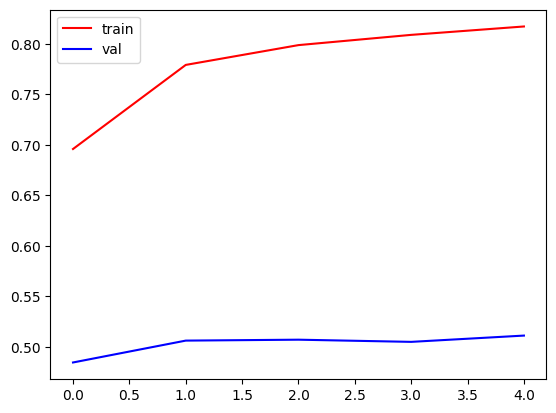

In [ ]:
model.save('model_inceptionV3_epoch5.h5')
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'],color ='r',label='train')
plt.plot(r.history['val_accuracy'],color ='b',label='val')
plt.legend()
plt.show()

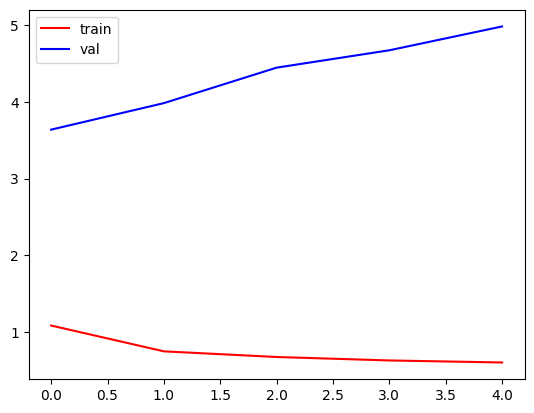

In [ ]:
plt.plot(r.history['loss'],color ='r',label='train')
plt.plot(r.history['val_loss'],color ='b',label='val')
plt.legend()
plt.show()

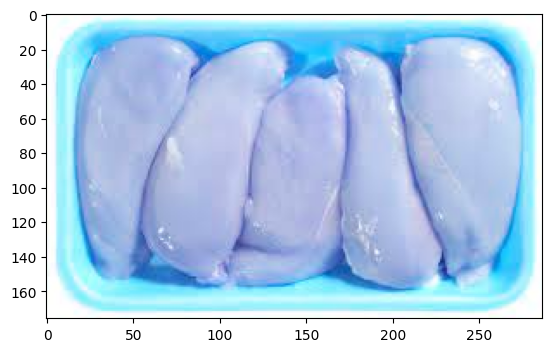

In [ ]:
img= cv2.imread('/content/download.jpg')
plt.imshow(img)

In [ ]:
img=cv2.resize(img,IMAGE_SIZE)
input=img.reshape((1,224,224,3))
model.predict(input)

1/1 [==============================] - 4s 4s/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 8.7344123e-15, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        7.7736911e-26, 0.0000000e+00, 2.0786321e-27, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0834447e-25, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 4.1599331e-30, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]], dtype=float32)

In [ ]:
category = {
                1: 'Apple',
                2: 'Bean',
                3: 'Bitter_Gourd',
                4: 'Bottle_Gourd',
                5: 'Brinjal',
                6: 'Broccoli',
                7: 'Cabbage',
                8: 'Capsicum',
                9: 'Cauliflower',
                10: 'Cucumber',
                11: 'Garlic',
                12: 'Ginger',
                13: 'Lemon',
                14: 'Mango',
                15: 'Melon',
                16: 'Noodles-Pasta',
                17: 'Papaya',
                18: 'Pumpkin',
                19: 'Radish',
                20: 'Red-Beet',
                21: 'Rice',
                22: 'bacon',
                23: 'banana',
                24: 'bread',
                25: 'butter',
                26: 'carrots',
                27: 'cheese',
                28: 'chicken',
                29: 'eggPlant',
                30: 'eggs',
                31: 'fish',
                32: 'lettuce',
                33: 'meat',
                34: 'milk',
                35: 'onions',
                36: 'potatoes',
                37: 'sausages',
                38: 'spinach',
                39: 'tomato',
                40: 'yogurt'}



In [ ]:

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(category[index-1]))
    plt.imshow(img_array)



In [ ]:
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1

    true=filedir.split('/')[-1]

    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))

    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=IMAGE_SIZE)
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)

        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

1/1 [==============================] - 0s 31ms/step


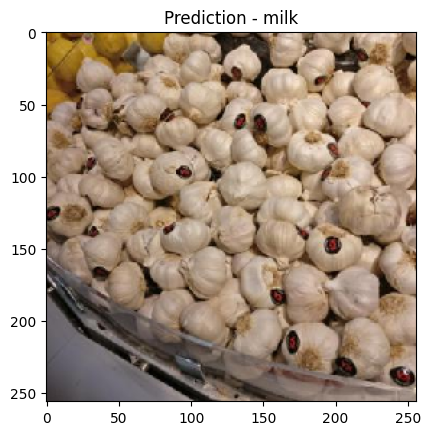

In [ ]:
predict_image('/content/dataset/test/Garlic/Garlic_021.jpg',model)